# PU-learning

### Data set sklearn.datasets -> circles

In [58]:
import pandas as pd #數據處理
import numpy as np  #隨機取數
import matplotlib.pyplot as plt   #繪圖
#把繪圖套入ipython中的魔法函數%
%matplotlib inline  
plt.rcParams['figure.figsize'] = 7,7   # 圖片大小
plt.rcParams['font.size'] = 14         # 圖片文字大小


In [59]:
# 建立數據集
from sklearn.datasets import make_circles
#n_samples---返回數據數量
#noise ---高斯模糊片差
#shuffle ---洗牌樣品
#factor --- 內圈外圈比例
X, y = make_circles(
    n_samples = 6000, noise = 0.1, 
    shuffle = True, factor = .65
)
#將參數變成表格(二維)
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y) #將參數放入一個一維的list

In [60]:
# 檢查數據內容
print('%d 筆資料 和 %d 種特徵' % (X.shape))
print('%d 筆資料中有 %d 筆正實例' % (len(y), sum(y)))

6000 筆資料 和 2 種特徵
6000 筆資料中有 3000 筆正實例


In [61]:
# 保留原本的標籤，之後比對使用
y_orig = y.copy()

# 取消一些標記的數據
hidden_size = 2700
#loc可以選擇數據
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

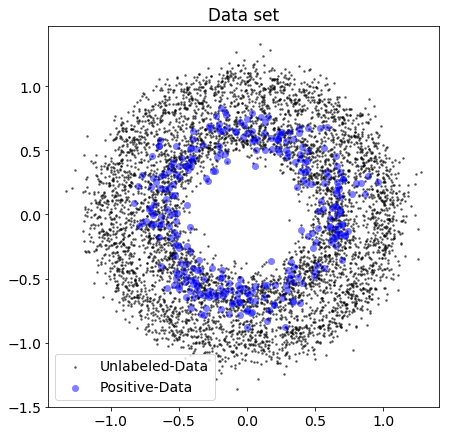

In [62]:
# 劃出數據圖
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled-Data'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive-Data'
)
plt.legend()
plt.title('Data set')
plt.show()

# Standard classifier 傳統隨機森林法


In [63]:
# 使用一般的隨機森林算法
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # 使用1000顆決策樹
    n_jobs = -1           # 使用全部的CPU合運算
)
rf.fit(X, y)

# 儲存次方法給定的分數
results = pd.DataFrame({
    'truth'      : y_orig,   # 真實標籤
    'label'      : y,        # 預測標籤
    'output_std' : rf.predict_proba(X)[:,1]   # 隨機森林分數
}, columns = ['truth', 'label', 'output_std'])

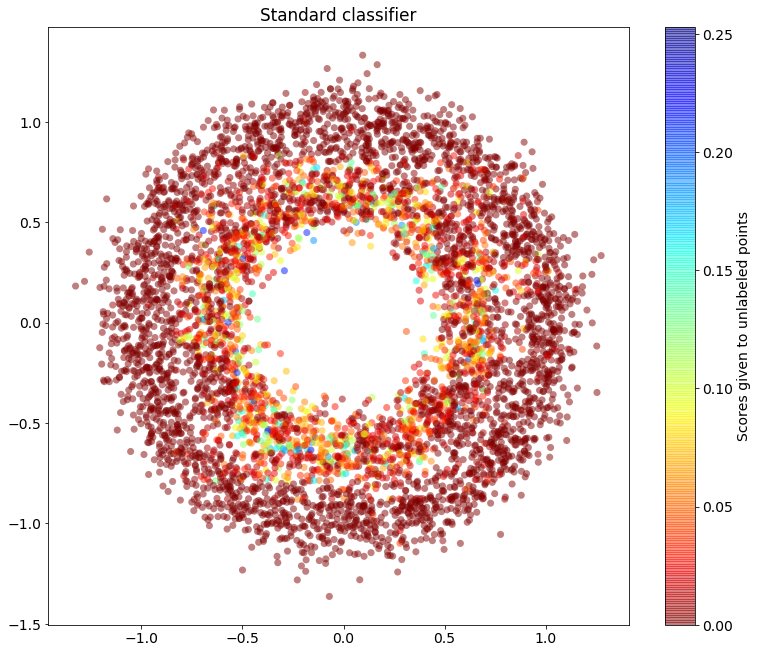

In [64]:
# 將隨機森林結果可視化
plt.rcParams['figure.figsize'] = 13,11 #圖片像素
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_std, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()


## PU-Bagging

### 1.他是透過將正實例和未標記實例結合創建數據集，並進行替換

### 2.將正數視為正實例，負數視為未標記實例

### 3.將分類器應用於隨機樣本中未包含的人合未標記數據點，稱為OOB(out of bag)，並記錄其分數

### 重複上面三個步驟，最後每個點OOB分數為每次分配分數的平均值


In [65]:
# 使用1000棵決策樹
from sklearn.tree import DecisionTreeClassifier
n_estimators = 1000
estimator = DecisionTreeClassifier()

# 追蹤正實例和未標記實例的索引
iP = y[y > 0].index
iU = y[y <= 0].index

# 對每個數據點記錄他是OOB的次數
num_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

# 記錄OOB分數的總合
sum_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

for _ in range(n_estimators):
    # 獲取本輪未標記點的 bootstrap sample(引導樣本)
    ib = np.random.choice(iU, replace=True, size = len(iP))

    # 找到本輪的OOB數據
    i_oob = list(set(iU) - set(ib))

    # 獲取訓練數據 (所有正實例和 bootstrap sample(未標記實例)還有建立樹
    Xb = X[y > 0].append(X.loc[ib])
    yb = y[y > 0].append(y.loc[ib])
    estimator.fit(Xb, yb)
    
    # 紀錄本輪OOB分數還有OOB次數
    sum_oob.loc[i_oob, 0] += estimator.predict_proba(X.loc[i_oob])[:,1]
    num_oob.loc[i_oob, 0] += 1

# 最後儲存平均的OOB分數
results['output_bag'] = sum_oob / num_oob


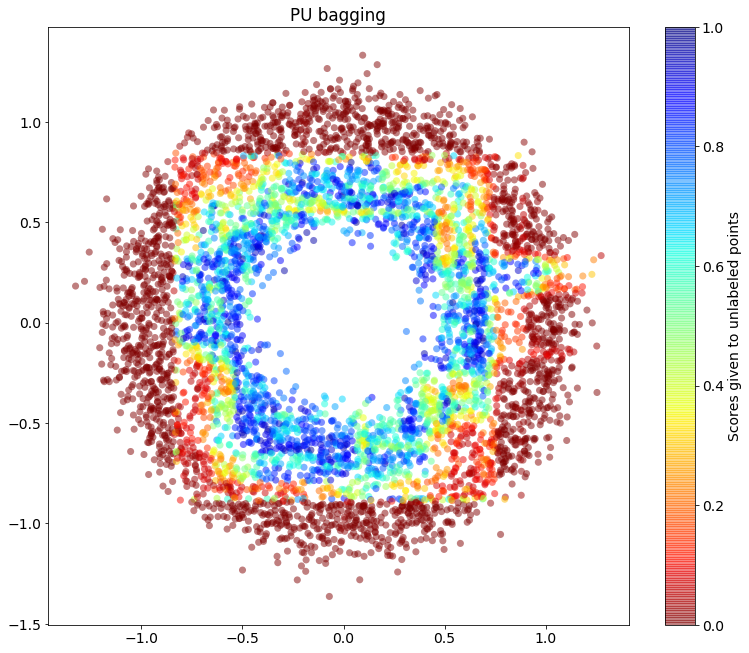

In [66]:
# 可視化裝袋法結果
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_bag, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU bagging')
plt.show()

# Two-step PU learning

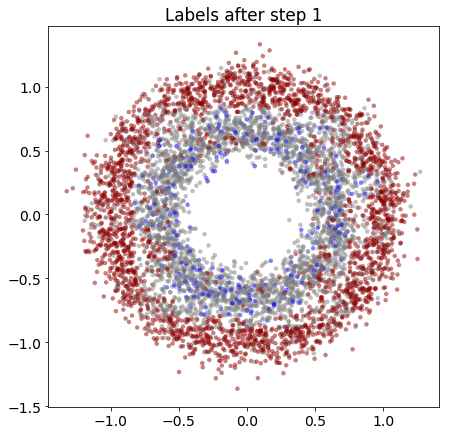

Step 1 labeled 0 new positives and 2609 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 304 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 98 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 58 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 46 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 31 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 20 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 20 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 24 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 18 new negatives.
Doing step 2... 

In [67]:
# 創建一個新的目標向量，1表示正實例，-1表示未標記實例，和 0表示“可靠的否定實例”（開始時沒有可靠的否定）
ys = 2 * y - 1

# 從之前獲得的分數
pred = rf.predict_proba(X)[:,1]

# 找出正實例的分數範圍
range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]

# 第一步
# 任何未標記的點若大於範圍或小於範圍，相對應的標記他
iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

# 可視化第一步結果
plt.rcParams['figure.figsize'] = 7,7
cdict = {-1:'gray', 0:'darkred', 1:'blue'}
plt.scatter(
    X.feature1, X.feature2, 
    c = [cdict[k] for k in ys], 
    linewidth = 0, s = 20, alpha = 0.5
)
plt.title('Labels after step 1')
plt.show()   

# 用於步驟2的分類器
rf2 = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)

# 限制迭代10次，可以任意調整只是會很花時間
for i in range(10):
    # 如果步驟一沒有找到新標籤，就完成了
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print(
        'Step 1 labeled %d new positives and %d new negatives.' 
        % (len(iP_new), len(iN_new))
    )
    print('Doing step 2... ', end = '')
    
    # 第二步
    # 重新預測新標籤和取得新分數
    rf2.fit(X, ys)
    pred = rf2.predict_proba(X)[:,-1]
    
    # 找出正實例的分數範圍
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
    
    # 重複步驟1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0
    
    
# 最後，獲得此方法的分數    
results['output_stp'] = pred

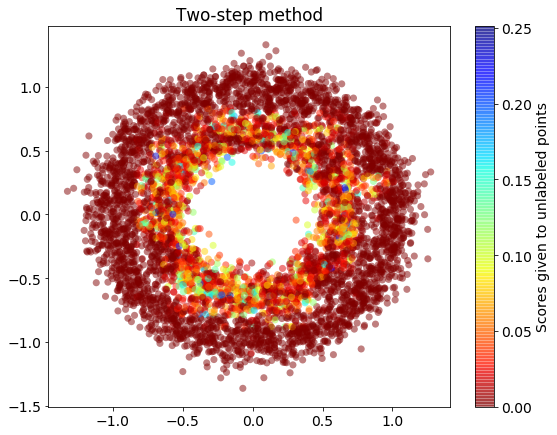

In [68]:
# 可視化兩步法結果
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_stp, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

In [69]:
# 計算三種方法的每個數據點平均分數
results['output_all'] = results[[
    'output_std', 'output_bag', 'output_stp'
]].mean(axis = 1)

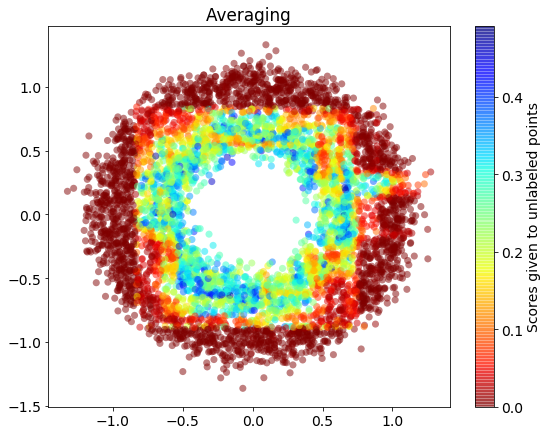

In [70]:
# 可視化平均分數
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_all, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Averaging')
plt.show()

In [76]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )
    y_bag.append(
        results[results.label == 0].sort_values(
            'output_bag', ascending = False
        ).head(t).truth.mean()
    )
#     y_skb.append(
#         results[results.label == 0].sort_values(
#             'output_skb', ascending = False
#         ).head(t).truth.mean()
#     )
    y_stp.append(
        results[results.label == 0].sort_values(
            'output_stp', ascending = False
        ).head(t).truth.mean()
    )
    y_all.append(
        results[results.label == 0].sort_values(
            'output_all', ascending = False
        ).head(t).truth.mean()
    )
    

In [77]:
# 檢查長途PU包裝和使用BaggingClassifierPU之間的區別
#[y_bag[i] - y_skb[i] for i in range(len(y_bag))]

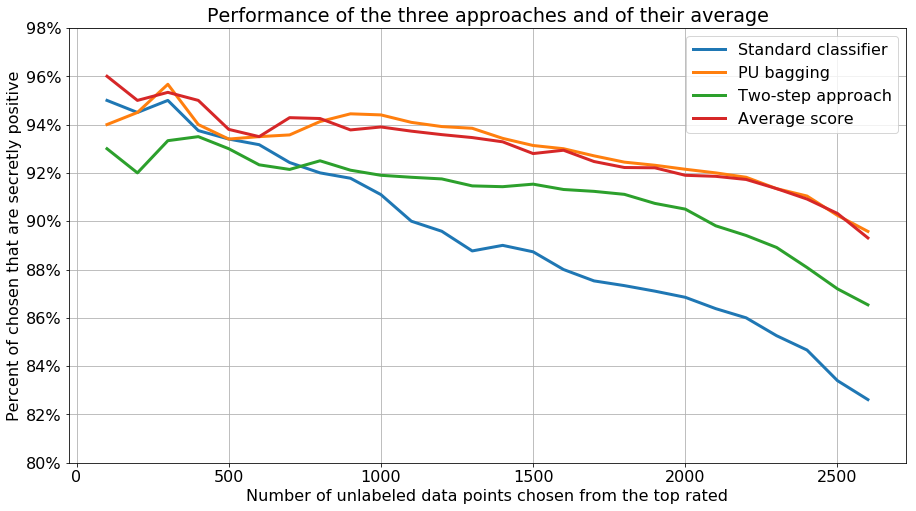

In [78]:
# 效能圖
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    ts, y_bag,
    ts, y_stp,
    ts, y_all,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Standard classifier', 
    'PU bagging', 
    'Two-step approach', 
    'Average score'
])
ylim = plt.gca().get_ylim()
plt.title('Performance of the three approaches and of their average')
plt.grid()
plt.show()